In [1]:
# Importing all the neccessary libraries
import torch
import torchaudio
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torchaudio.functional as F
from IPython.display import Audio, display
import random
import os
from torchaudio.datasets import SPEECHCOMMANDS
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

#Check if GPU is available or not
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Loading the dataset
dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./",
                                             download=True)

#Checking how many samples in the dataset
print("Number of samples:", len(dataset))
print(dataset[100000])

#Accessing a sample(Gtting to know about the data structure and shape of the sample)
waveform, sample_rate, label,speaker_id, utterance_number = dataset[100000]

print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)
print("Label:", label)
print("Speaker ID:", speaker_id)
print("Utterance number:", utterance_number)


cuda


100%|██████████| 2.26G/2.26G [01:46<00:00, 22.9MB/s]


Number of samples: 105829
(tensor([[0.0001, 0.0002, 0.0002,  ..., 0.0016, 0.0014, 0.0011]]), 16000, 'yes', '94d370bf', 2)
Waveform shape: torch.Size([1, 16000])
Sample rate: 16000
Label: yes
Speaker ID: 94d370bf
Utterance number: 2


In [2]:
#List of desired 10 subclasses
wanted_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

#Custom filtered dataset
class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)
        self._walker = [w for w in self._walker if self._get_label(w) in wanted_words]

    def _get_label(self, fileid):
        return Path(fileid).parent.name

    def __getitem__(self, n):
        waveform, sample_rate, label, *_ = super().__getitem__(n)
        return waveform, sample_rate, label

#Replacing the original dataset with the filtered one
dataset = SubsetSC()
#Checking the number of data in the filtered dataset
print(len(dataset))


38546


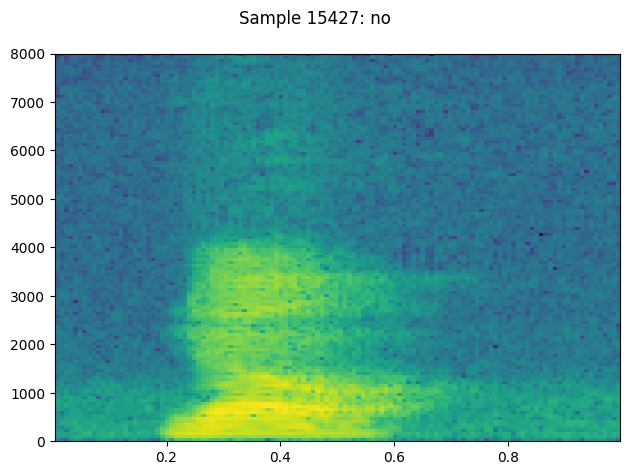

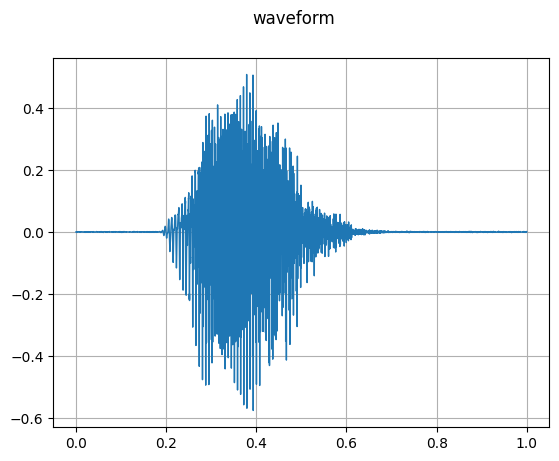

In [3]:
#Defining a function to plot the spectogram of the waveform
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()
    figure, ax = plt.subplots()
    ax.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()
#Defining a function to plot the waveform of the audio sample
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
#Listening to and printing the spectogram and waveform of randomly picked samples
i = random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
display(Audio(waveform.numpy(), rate=sample_rate))
plot_waveform(waveform, sample_rate)

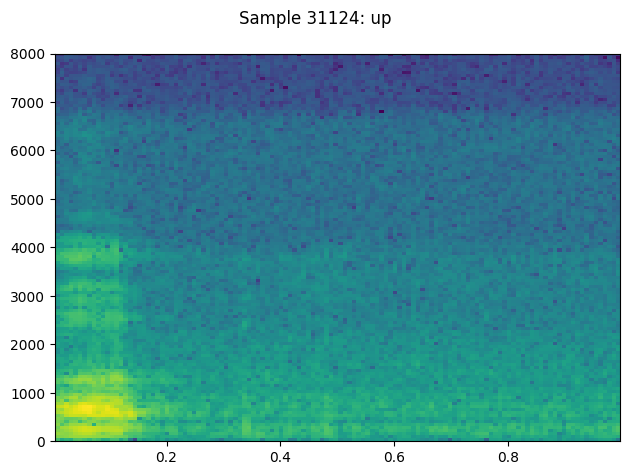

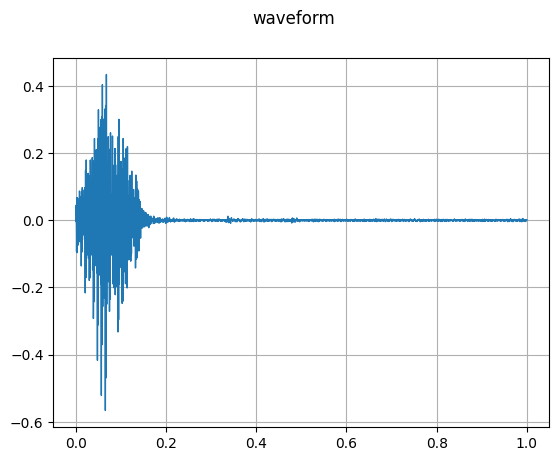

In [4]:
i = random.randint(0,38546)
waveform, sample_rate, label= dataset[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
display(Audio(waveform.numpy(), rate=sample_rate))
plot_waveform(waveform, sample_rate)

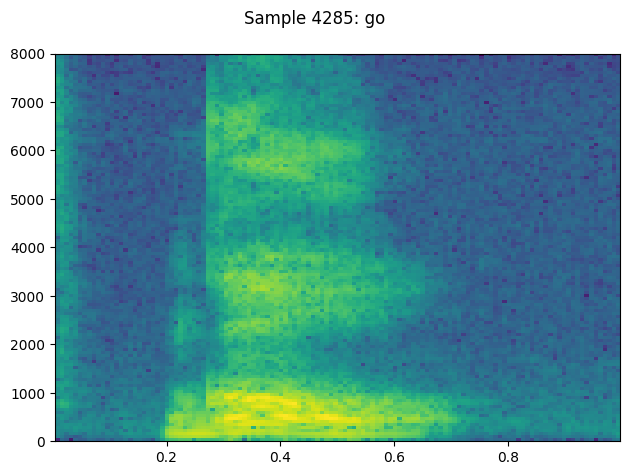

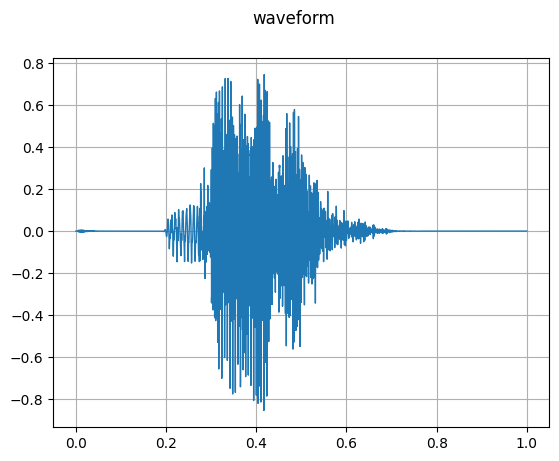

In [5]:
i = random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
display(Audio(waveform.numpy(), rate=sample_rate))
plot_waveform(waveform, sample_rate)

The above given samples are all varying from 0 second to 1 Seocnd.

Now let us check the consistency of sampling rate.

In [6]:
#Checking the sampling rate
waveform, sample_rate, label= dataset[1]
print("Sample rate:", sample_rate)

Sample rate: 16000


In [7]:
waveform, sample_rate, label = dataset[1489]
print("Sample rate:", sample_rate)

Sample rate: 16000


In [8]:
waveform, sample_rate, label = dataset[38222]
print("Sample rate:", sample_rate)

Sample rate: 16000


The sampling rate is consistent and 16kHz


In [9]:
#Applying the mffc transform
sample_rate=16000
mfcctransform = torchaudio.transforms.MFCC(
sample_rate=sample_rate,
n_mfcc=40,
melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40, "center": False}).to(device)

#Feature scaling the mfcc transform
def extract_features(waveform):
    mfcc = mfcctransform(waveform).squeeze(0)
    return (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)


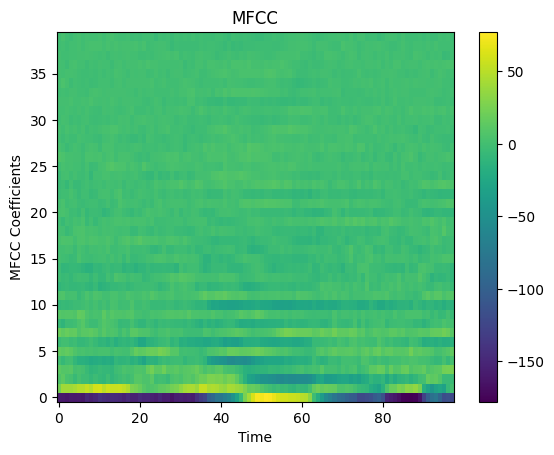

In [10]:
#Visualizing mfcc's for a few samples
i=random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
waveform=waveform.to(device)
mfcc = mfcctransform(waveform)
plt.imshow(mfcc[0].cpu().numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


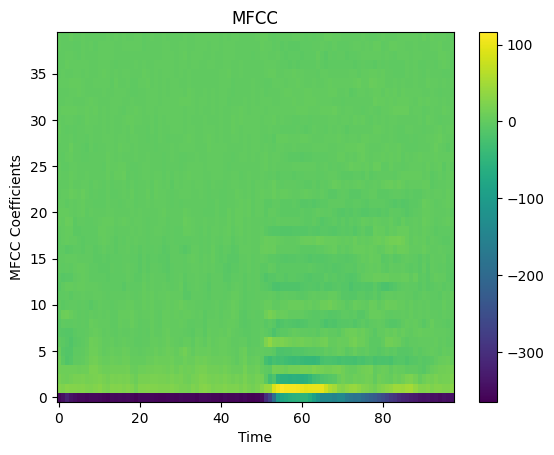

In [11]:
i=random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
waveform=waveform.to(device)
mfcc = mfcctransform(waveform)
plt.imshow(mfcc[0].cpu().numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

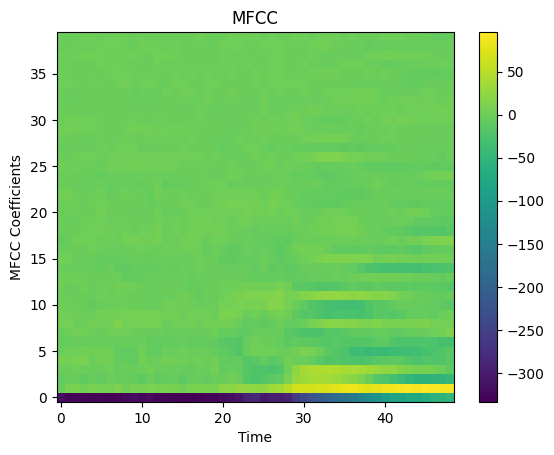

In [12]:
i=random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
waveform=waveform.to(device)
mfcc = mfcctransform(waveform)
plt.imshow(mfcc[0].cpu().numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

In [13]:
#Creating a custom dataset
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.join(self._path, line.strip()) for line in f]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

target_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_to_index = {label: i for i, label in enumerate(target_labels)}

def label_filter(label):
    return label in target_labels

def label_to_id(label):
    return label_to_index[label]

#Defining functions for different data augmentations
def add_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise
def time_stretch(waveform, rate=1.1):
    return torchaudio.functional.resample(waveform, orig_freq=16000, new_freq=int(16000 * rate))
def data_augmentation(waveform, sample_rate=16000):
    if torch.rand(1).item() < 0.5:
        waveform = add_noise(waveform, noise_level=0.01)
    if torch.rand(1).item() < 0.3:
        steps = torch.randint(-2, 3, (1,)).item()  # -2 to +2
    return waveform

class SubsetDataset(torch.utils.data.Dataset):
    def __init__(self, subset="training", transform=None, max_length=16000):
        self.data = SubsetSC(subset=subset)
        self.transform = transform
        self.max_length = max_length
        self.augment = self.augment = (subset == "training")

        self.training = (subset == "training")
        self.samples = [(waveform, sample_rate, label) for (waveform, sample_rate, label, *_)
                        in self.data if label_filter(label)]
    #Padding/ Truncating for a constant sequence length
    def pad_or_truncate(self, waveform):
        length = waveform.shape[1]
        if length > self.max_length:
            return waveform[:, :self.max_length]
        elif length < self.max_length:
            pad_amt = self.max_length - length
            return torch.nn.functional.pad(waveform, (0, pad_amt))
        return waveform

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]

        if self.augment and self.training:
            waveform = data_augmentation(waveform, sample_rate)#Applying the augmentations to the training dataset

        waveform = self.pad_or_truncate(waveform)
        waveform=waveform.to(device)
        if self.transform:
            waveform = self.transform(waveform)
            waveform = waveform.squeeze(0).transpose(0, 1)
        return waveform, label_to_id(label)

    def __len__(self):
        return len(self.samples)

train_dataset = SubsetDataset(subset="training", transform=extract_features)
val_dataset = SubsetDataset(subset="validation", transform=extract_features)
test_dataset= SubsetDataset(subset="testing", transform=extract_features)

In [14]:
#Defining the collate function
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence(waveforms, batch_first=True)
    return waveforms, torch.tensor(labels)


In [15]:
#Creating data loaders
batch_size=100
train_loader= DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
test_loader= DataLoader(test_dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_fn)
val_dataloader= DataLoader(val_dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_fn)

In [18]:
#Defining the Model
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Use last time step
        return self.fc(out)

model = RNNClassifier(40, 128, len(wanted_words)).to(device)

#Setting up the loss and optimizer functions
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




Epoch 1: Train Loss=2.2816, Val Loss=2.2999, Train Acc=0.1324, Val Acc=0.1242
Epoch 2: Train Loss=2.2883, Val Loss=2.2936, Train Acc=0.1309, Val Acc=0.1226
Epoch 3: Train Loss=2.2907, Val Loss=2.2695, Train Acc=0.1285, Val Acc=0.1399
Epoch 4: Train Loss=2.2689, Val Loss=2.3137, Train Acc=0.1426, Val Acc=0.1267
Epoch 5: Train Loss=2.2813, Val Loss=2.3042, Train Acc=0.1350, Val Acc=0.1134
Epoch 6: Train Loss=2.2900, Val Loss=2.2994, Train Acc=0.1259, Val Acc=0.1075
Epoch 7: Train Loss=2.2940, Val Loss=2.2719, Train Acc=0.1250, Val Acc=0.1439
Epoch 8: Train Loss=2.2584, Val Loss=2.3552, Train Acc=0.1517, Val Acc=0.1253
Epoch 9: Train Loss=2.3040, Val Loss=2.2897, Train Acc=0.1096, Val Acc=0.1334
Epoch 10: Train Loss=2.2908, Val Loss=2.2756, Train Acc=0.1242, Val Acc=0.1369


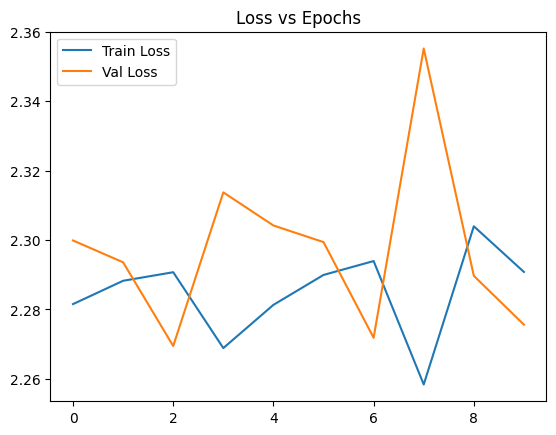

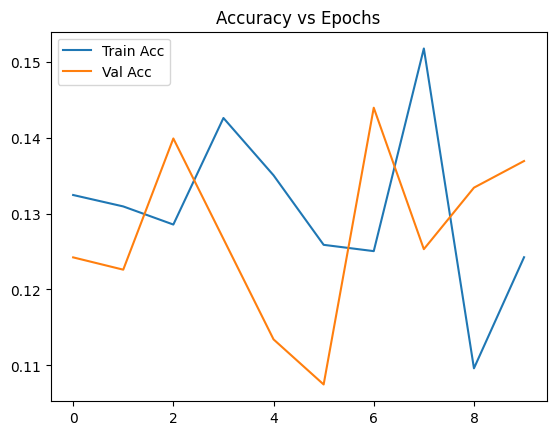

In [19]:
#Training the model
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(10):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    val_loss /= len(val_dataloader)
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

#Plotting the graphs
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()


Test Accuracy: 0.1510, F1-score: 0.0948


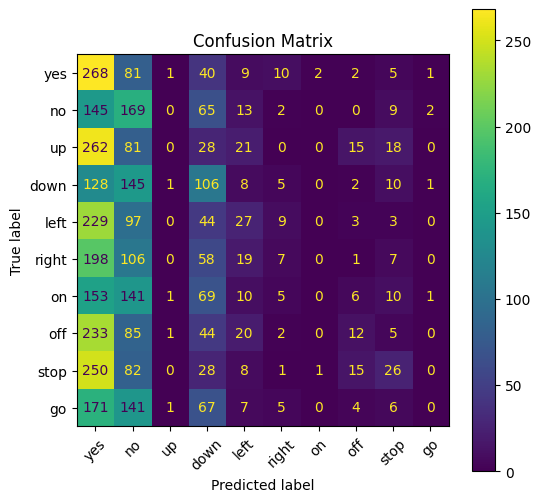

In [20]:
#Evaluating the model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.numpy())

#Printing Accuracy and F1 Scores
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

#Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(wanted_words))))
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=wanted_words)
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
